## Sagnac Frequency - Backscatter Correction - Multi Day - Case 2

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [36]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-11-25 00:00")
config['tend'] = UTCDateTime("2023-11-27 12:00")

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [37]:
def __load_backscatter_data(tbeg, tend, ring, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)-86400).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(dat)
        dat_str = str(dat)[:10].replace("-","")
        file = f"FJ{ring}_{dat_str}_backscatter.pkl"

        if not os.path.isfile(path_to_data+file):
            _path = data_path+"sagnac_frequency/data/"

            out = DataFrame()
            for m in range(24):
                hour = str(m).rjust(2, '0')+":00:00"
                filename = f"FJU_{dat_str}_{hour}_backscatter.pkl"
                try:
                    _df = read_pickle(_path+filename)
                    out = concat([out, _df])
                except:
                    print(f" -> failed: {_path}{filename}")
                    continue

            if not out.empty:
                print(f" -> write to: {_path}backscatter/FJU_{dat_str}_backscatter.pkl")
                out.to_pickle(f"{_path}backscatter/FJU_{dat_str}_backscatter.pkl")
            else:
                continue

        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    df.reset_index(inplace=True)

    return df

In [38]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

2023-11-25 00:00:00
2023-11-26 00:00:00


### Cut corrupt data periods

In [39]:
# times = [("2023-09-19 11:45", "2023-09-19 14:40"),
#          ("2023-09-19 15:50", "2023-09-19 16:00"),
#          ("2023-09-19 20:30", "2023-09-20 08:10"),
#          ("2023-09-20 09:50", "2023-09-20 12:00"),
#          ("2023-09-21 21:30", "2023-09-22 06:40"),
#          ("2023-09-22 11:30", "2023-09-22 12:30"),
#          ("2023-09-22 14:30", "2023-09-22 15:00"),
#         ]


# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)

### Compute PSD

In [40]:
from functions.multitaper_psd import __multitaper_psd

dat1 = np.array((bs.fj_fs - bs.fj_fs.mean()).replace(np.nan, 0))
dat2 = np.array((bs.w_s - bs.w_s.mean()).replace(np.nan, 0))

dat1 = dat1 - np.mean(dat1)
dat2 = dat2 - np.mean(dat2)

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

f1, psd1, pha1 = __get_fft(dat1, 60)
f2, psd2, pha2 = __get_fft(dat2, 60)


### Load and convert tilt

In [41]:
def __to_tilt(data):
    from numpy import pi, sqrt, arccos, deg2rad, arcsin
    return (arcsin((data * 632.8e-9 * 3) / ( (2*pi/86400) * 36/3 * sqrt(3) )) - deg2rad(48.162941))

In [42]:
def __conversion_to_tilt(st, conf):

    st0 = st.copy()

    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")

    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [43]:
fs_tilt = __to_tilt(bs.w_s)

In [70]:
bromy = __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)
bromy += __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)

In [71]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

bromy = __conversion_to_tilt(bromy, confTilt['BROMY'])

bromy.trim(config['tbeg'], config['tend'])

bromy2 = bromy.copy()
bromy2.detrend("simple")
bromy2.filter("lowpass", freq=0.001, corners=4, zerophase=True)
bromy2= bromy2.decimate(6, no_filter=True)
bromy2= bromy2.decimate(10, no_filter=True)

temp_gradient = np.gradient(bromy2[0].data, 60)[10:-10]

bromy2.trim(bs.time1[0], bs.time1[bs.time1.size-1])


  -> converted data of DROMY


2 Trace(s) in Stream:
BW.DROMY..LAT | 2023-11-25T00:00:00.000000Z - 2023-11-26T23:59:00.000000Z | 60.0 s, 2880 samples
BW.DROMY..LAN | 2023-11-25T00:00:00.000000Z - 2023-11-26T23:59:00.000000Z | 60.0 s, 2880 samples

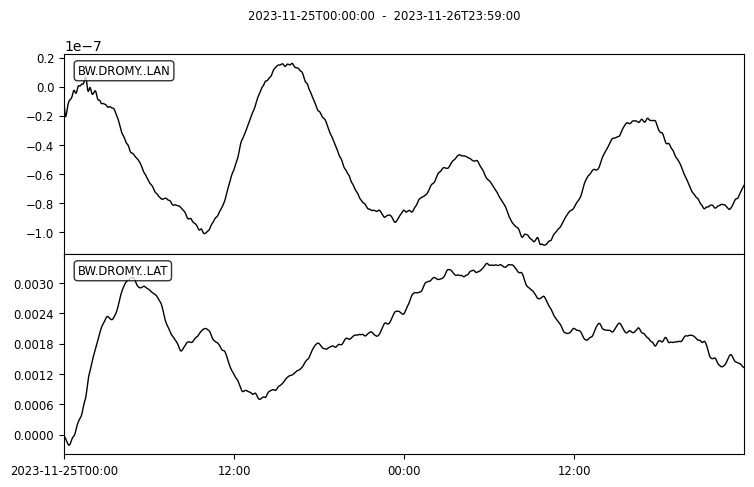

In [72]:
bromy2.plot(equal_scale=False);


### Load WROMY data

In [ ]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws1 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS1", config['tbeg'], config['tend'])
ws5 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS5", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

In [ ]:
ws1 = ws1.decimate(6, no_filter=False)
ws1 = ws1.decimate(10, no_filter=False)

ws5 = ws5.decimate(6, no_filter=False)
ws5 = ws5.decimate(10, no_filter=False)

ws9 = ws9.decimate(6, no_filter=False)
ws9 = ws9.decimate(10, no_filter=False)

In [ ]:
from functions.smoothing import __smooth

ws1_T = ws1.select(channel="*T")[0].data
ws1_T_smooth = __smooth(ws1_T, 60)
ws1_gradient = np.gradient(ws1_T_smooth, 5)

ws5_T = ws5.select(channel="*T")[0].data
ws5_T_smooth = __smooth(ws5_T, 60)
ws5_gradient = np.gradient(ws5_T_smooth, 5)

ws9_T = ws9.select(channel="*T")[0].data
ws9_T_smooth = __smooth(ws9_T, 60)
ws9_gradient = np.gradient(ws9_T_smooth, 5)

In [ ]:
# plt.plot(ws1_gradient)
# plt.plot(ws5_gradient)
plt.plot(ws1_gradient-ws5_gradient)

plt.ylim(-0.01, 0.01)

## Plotting

### CWT

In [15]:
from functions.compute_cwt import __compute_cwt

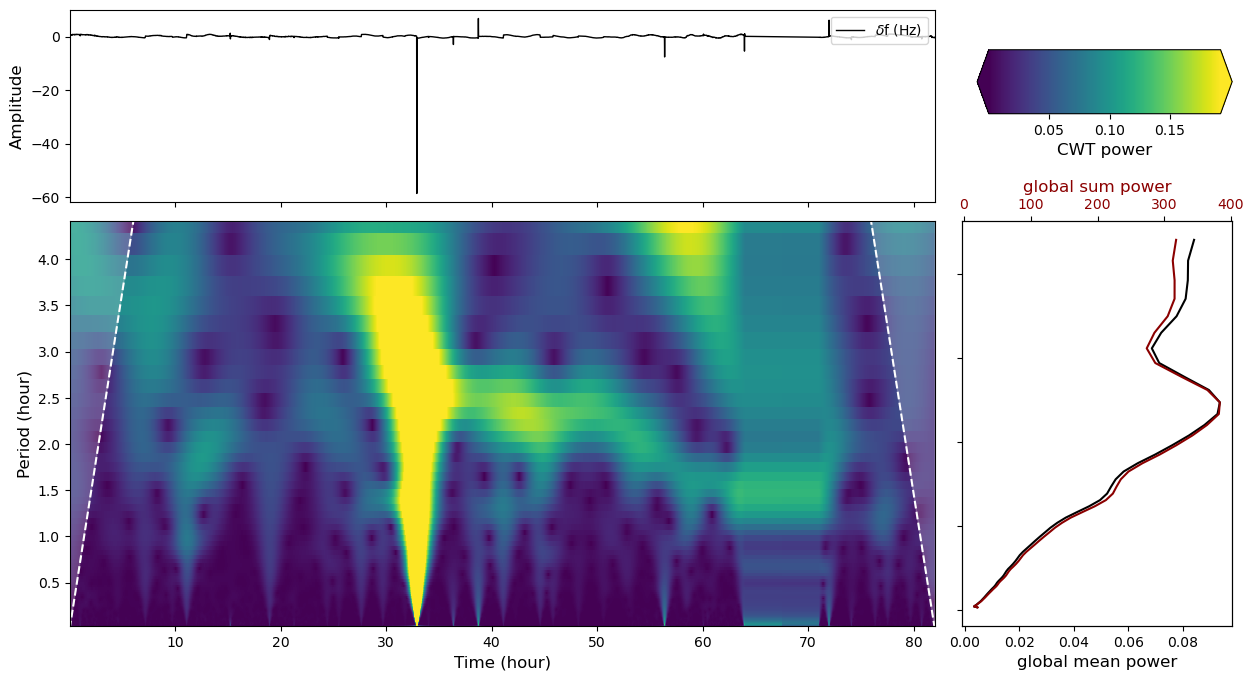

In [16]:
ttt = np.array(bs.time_sec)
arr = np.array(bs.w_s)
dt = 60 # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="$\delta$f (Hz)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_CWT.png", format="png", dpi=200, bbox_inches='tight')


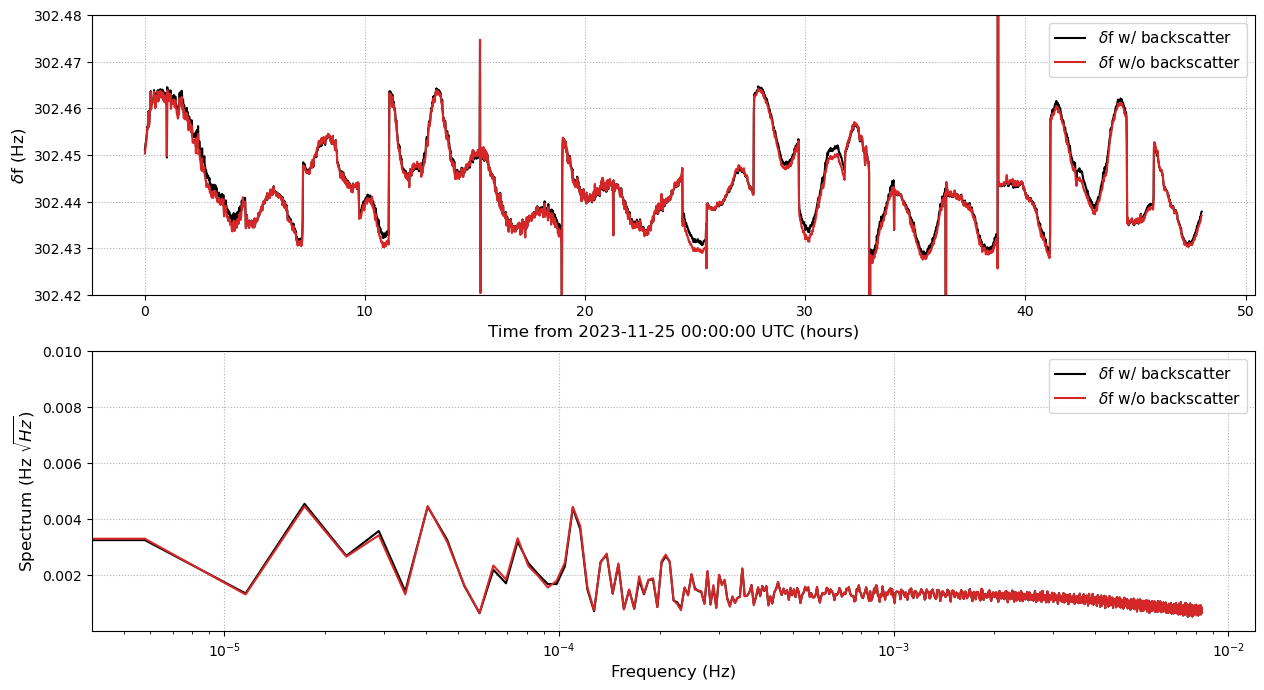

In [57]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec/3600, bs.fj_fs, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec/3600, bs.w_s, color="tab:red", label=f"$\delta$f w/o backscatter")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    ax[0].set_ylim(302.42, 302.48)
    ax[1].set_ylim(1e-6, 1e-2)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    # ax[1].axvline(1/(6*3600), ls="--", color="grey", zorder=0)
    # ax[1].axvline(1/(14*3600), ls="--", color="grey", zorder=0)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_PSD.png", format="png", dpi=200, bbox_inches='tight')


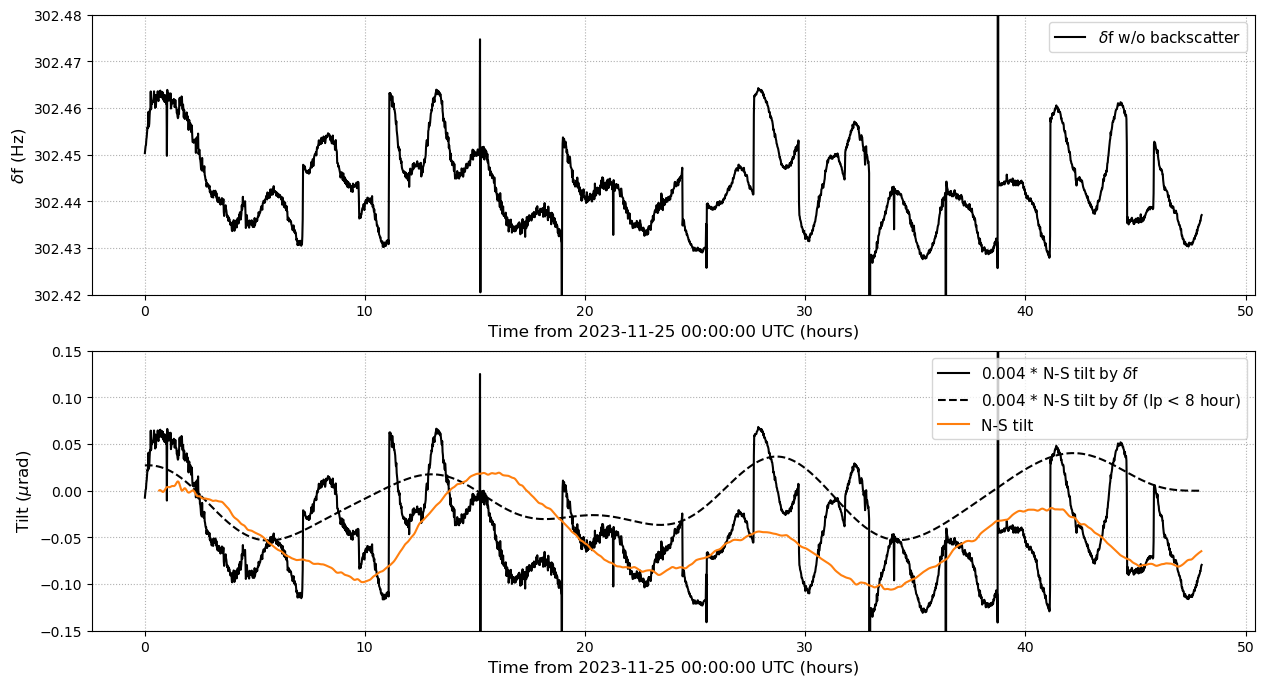

In [81]:
def __makeplot():

    # dat = np.array((fs_tilt-np.mean(fs_tilt[:10])))
    dat = np.array(fs_tilt)

    tr = Trace()
    tr.data = dat
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    hr = 8
    tr.detrend("demean")
    tr.detrend("simple")
    # tr.taper(0.001)
    tr.filter("lowpass", freq=1/(hr*3600), corners=4, zerophase=True)

    fs_tilt_lp = tr.data


    Nrow, Ncol = 2, 1

    font = 12

    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    # ax[0].plot(bs.time_sec/3600, bs.fj_fs, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec/3600, bs.w_s, color="black", label=f"$\delta$f w/o backscatter")
    ax[0].set_ylim(302.42, 302.48)
    ax[0].ticklabel_format(useOffset=False)


    ax[1].plot(bs.time_sec/3600, (fs_tilt-np.mean(fs_tilt[:5]))*tilt_scaling*0.004, color="k", label=f"0.004 * N-S tilt by $\delta$f")
    ax[1].plot(bs.time_sec/3600,
               fs_tilt_lp*tilt_scaling*0.004,
               ls="--", color="k", label=f"0.004 * N-S tilt by $\delta$f (lp < {hr} hour)",
              )

    bromy_tilt = bromy2.select(channel="*N")[0].data
    ax[1].plot(bromy2.select(channel="*N")[0].times()[40:]/3600,
               (bromy_tilt-np.mean(bromy_tilt[40:50]))[40:]*tilt_scaling,
               color="tab:orange", label=f"N-S tilt",
              )

    # ax[1].set_ylim(-59.5, -59.25)
    ax[1].set_ylim(-0.15, 0.15)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_Tilt.png", format="png", dpi=200, bbox_inches='tight')


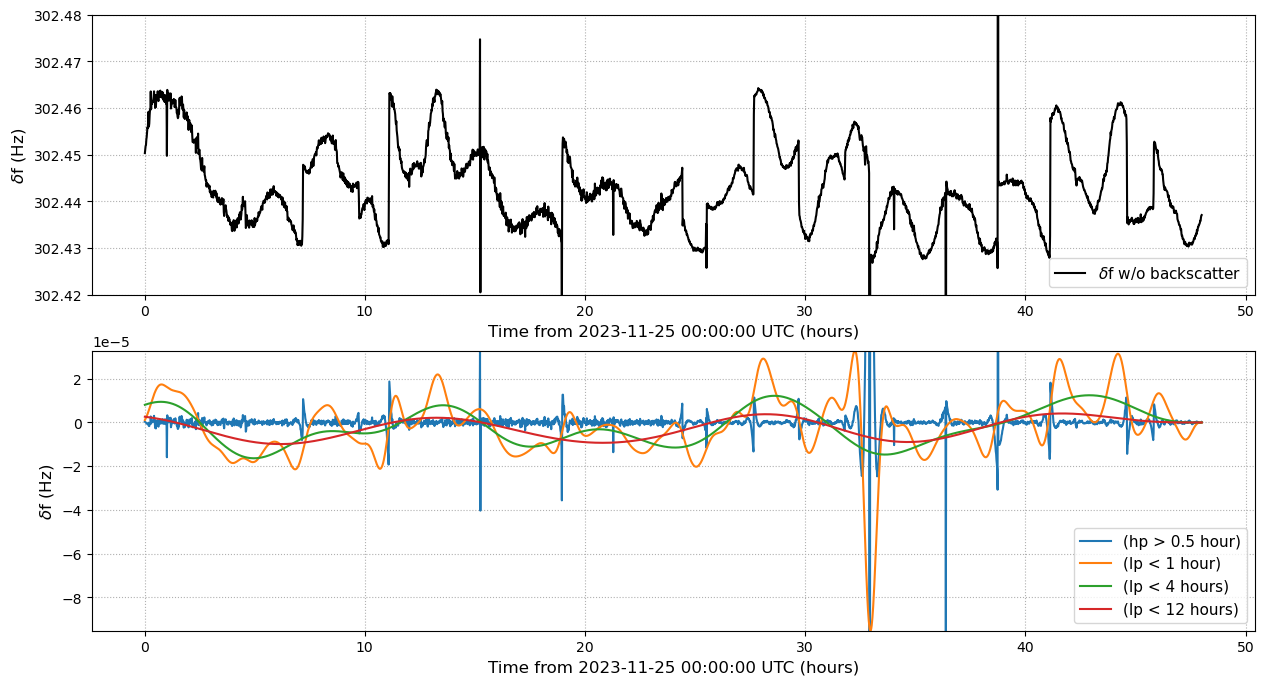

In [82]:
def __makeplot():

    dat = np.array(fs_tilt)

    tr = Trace()
    tr.data = dat
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    ## --------------------------------------------
    flower0, flower0_str = 1/(0.5*3600), "0.5 hour"
    tr0 = tr.copy()
    tr0.detrend("simple")
    tr0.taper(0.01)
    tr0.filter("highpass", freq=flower0, corners=4, zerophase=True)

    fs_tilt_lp0 = tr0.data

    ## --------------------------------------------
    flower1, flower1_str = 1/(1*3600), "1 hour"
    tr1 = tr.copy()
    tr1.detrend("simple")
    tr1.taper(0.01)
    tr1.filter("lowpass", freq=flower1, corners=4, zerophase=True)

    fs_tilt_lp1 = tr1.data

    ## --------------------------------------------
    flower2, flower2_str = 1/(6*3600), "4 hours"
    tr2 = tr.copy()
    tr2.detrend("simple")
    tr2.taper(0.01)
    tr2.filter("lowpass", freq=flower2, corners=4, zerophase=True)

    fs_tilt_lp2 = tr2.data

    ## --------------------------------------------
    flower3, flower3_str = 1/(12*3600), "12 hours"
    tr3 = tr.copy()
    tr3.detrend("simple")
    tr3.taper(0.01)
    tr3.filter("lowpass", freq=flower3, corners=4, zerophase=True)

    fs_tilt_lp3 = tr3.data


    ## --------------------------------------------

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    # ax[0].plot(bs.time_sec/3600, bs.fj_fs, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec/3600, bs.w_s, color="black", label=f"$\delta$f w/o backscatter")
    ax[0].set_ylim(302.42, 302.48)
    ax[0].ticklabel_format(useOffset=False)


    ax[1].plot(bs.time_sec/3600, fs_tilt_lp0, ls="-", label=f"(hp > {flower0_str})")
    ax[1].plot(bs.time_sec/3600, fs_tilt_lp1, ls="-", label=f"(lp < {flower1_str})")
    ax[1].plot(bs.time_sec/3600, fs_tilt_lp2, ls="-", label=f"(lp < {flower2_str})")
    ax[1].plot(bs.time_sec/3600, fs_tilt_lp3, ls="-", label=f"(lp < {flower3_str})")


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=4, fontsize=font-1)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[1].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_ylim(min(fs_tilt_lp1), max(fs_tilt_lp1))

    plt.show();
    return fig


fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_Tilt.png", format="png", dpi=200, bbox_inches='tight')


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/core/trace.py:2158: UserWarning: The requested taper is longer than the trace. The taper will be shortened to trace length.
  warnings.warn(msg)


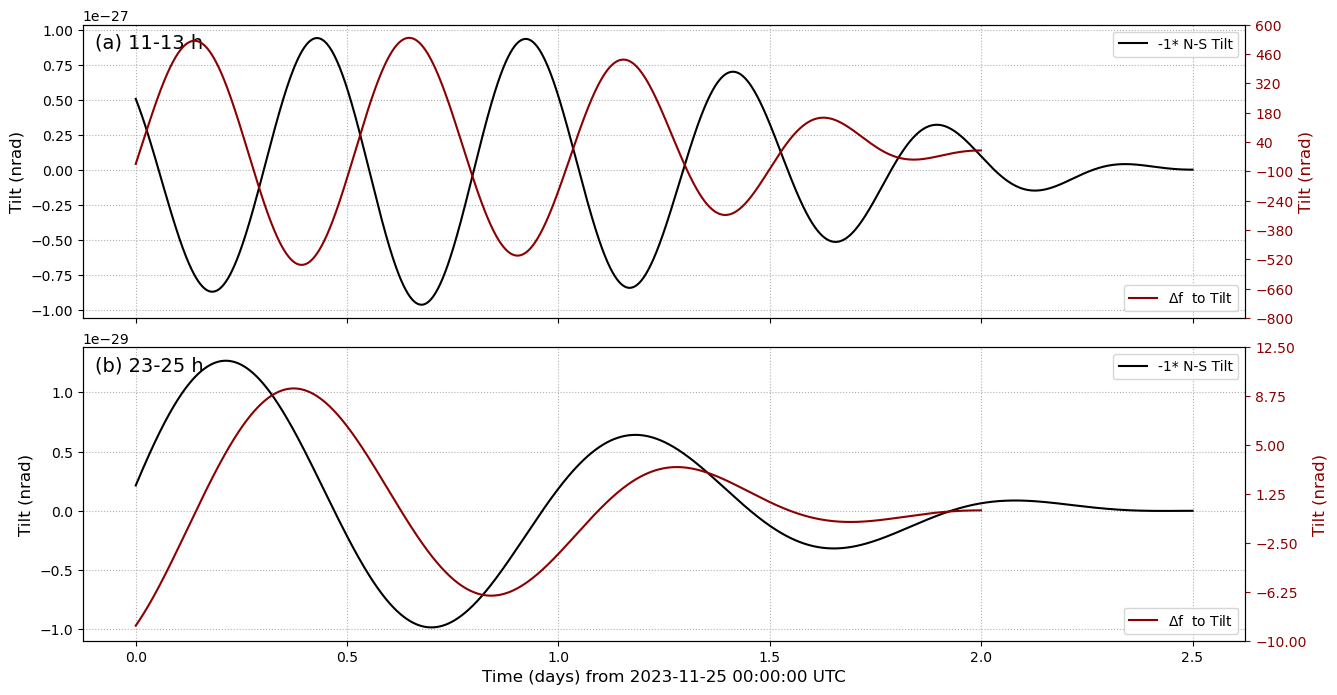

In [55]:
def __makeplot():

    def __to_tilt(data):
        from numpy import pi, sqrt, arccos, deg2rad, arcsin
        return (arcsin((data * 632.8e-9 * 3) / ( (2*pi/86400) * 36/3 * sqrt(3) )) - deg2rad(48.162941))

    f11 = 1/(13*3600)
    f12 = 1/(11*3600)

    f21 = 1/(25*3600)
    f22 = 1/(23*3600)

    detrend="linear"
    taper = 1
    corners = 2

    tr = Trace()
    tr.data = __to_tilt(np.array(bs.w_s))
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    tr1 = tr.copy()
    tr1 = tr1.detrend(detrend).detrend("simple")
    tr1 = tr1.taper(taper)
    tr1 = tr1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)

    tr2 = tr.copy()
    tr2 = tr2.detrend(detrend).detrend("simple")
    tr2 = tr2.taper(taper)
    tr2 = tr2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)


    tromy1 = bromy.select(channel="*N").copy();
    tromy1 = tromy1.detrend(detrend).detrend("simple")
    tromy1 = tromy1.taper(taper)
    tromy1 = tromy1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)


    tromy2 = bromy.select(channel="*N").copy();
    tromy2 = tromy2.detrend(detrend).detrend("simple")
    tromy2 = tromy2.taper(taper)
    tromy2 = tromy2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)


    Nrow, Ncol = 2, 1

    font = 12

    scaling = 1e9

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tromy1[0].times()/86400, -tromy1[0].data*scaling, color="black", label="-1* N-S Tilt")
    ax[1].plot(tromy2[0].times()/86400, -tromy2[0].data*scaling, color="black", label="-1* N-S Tilt")

    ax0 = ax[0].twinx()
    ax0.plot(tr1.times()/86400, tr1.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax1 = ax[1].twinx()
    ax1.plot(tr2.times()/86400, tr2.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax0.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")
    ax1.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax0.legend(loc=4)
    ax1.legend(loc=4)

    ax[0].text(.01, .97, '(a) 11-13 h', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b) 23-25 h', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # ax[0].set_ylim(-40, 40)
    # ax[1].set_ylim(-15, 15)

    ax0.tick_params(axis='y', colors='darkred')
    ax0.set_yticks(np.linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax[0].get_yticks())))

    ax1.tick_params(axis='y', colors='darkred')
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax[1].get_yticks())))

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_Tilt_Tides.png", format="png", dpi=150, bbox_inches='tight')


## Testing